In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import scipy.stats as st
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt

%load_ext line_profiler
%matplotlib inline

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
import os, sys 
sys.path.append(os.path.abspath("..\.."))
from src.simulators import StochasticSimulator, DeterministicSimulator 
from src.data_class import SimulationData

end_time = 300
n_steps = 300
n_traj = 200
time_grid_np = np.arange(0, end_time, int(end_time / n_steps))
time_grid_torch = torch.from_numpy(time_grid_np)


### Simulating in trans mRNA - sRNA  circuit

In [3]:
from examples.mrna_srna.mrna_srna_incis import mRNAsRNAInCis, cfg

data_set_incis = SimulationData()
reaction_system_incis = mRNAsRNAInCis()
ode_simulator = DeterministicSimulator(
    reaction_system=reaction_system_incis,
    cfg=cfg
)
ssa_simulator = StochasticSimulator(
    reaction_system=reaction_system_incis,
    data_set=data_set_incis,
    cfg=cfg
)
reaction_system_incis.params = {'beta_fmrna': 2}  # increasing fmRNA production rate
init_pops = torch.zeros((reaction_system_incis.n_species, ), dtype=torch.int64) #torch.randint(1, (reaction_system.n_species, ))
ssa_simulator.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)
ode_res_incis = ode_simulator.simulate(init_pops=np.zeros((reaction_system_incis.n_species,)), time_grid=time_grid_np)

### Simulating in trans mRNA - sRNA  circuit

In [4]:
from examples.mrna_srna.mrna_srna_intrans import mRNAsRNAInTrans, cfg

data_set_intrans = SimulationData()
reaction_system_intrans = mRNAsRNAInTrans()
ode_simulator = DeterministicSimulator(
    reaction_system=reaction_system_intrans,
    cfg=cfg
)
ssa_simulator = StochasticSimulator(
    reaction_system=reaction_system_intrans,
    data_set=data_set_intrans,
    cfg=cfg
)
init_pops = torch.zeros((reaction_system_intrans.n_species, ), dtype=torch.int64) #torch.randint(1, (reaction_system.n_species, ))
ssa_simulator.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)
ode_res_intrans = ode_simulator.simulate(init_pops=np.zeros((reaction_system_intrans.n_species,)), time_grid=time_grid_np)

### Comptuting the statistics on a grid

In [5]:
means_incis = data_set_incis.mean(time_range=time_grid_torch)
stds_incis = data_set_incis.std(time_range=time_grid_torch)
cov_incis = data_set_incis.coefficient_of_variation(time_range=time_grid_torch)

means_intrans = data_set_intrans.mean(time_range=time_grid_torch)
stds_intrans = data_set_intrans.std(time_range=time_grid_torch)
cov_intrans = data_set_intrans.coefficient_of_variation(time_range=time_grid_torch)

### Plotting results

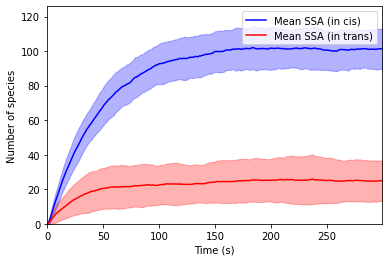

In [6]:
species_idx_incis = 1
plt.figure()
plt.plot(time_grid_torch, means_incis[species_idx_incis, :], 'b', label='Mean SSA (in cis)')
plt.fill_between(time_grid_torch, means_incis[species_idx_incis,:]+stds_incis[species_idx_incis, :], means_incis[species_idx_incis,:]-stds_incis[species_idx_incis, :], 
                 color='b', alpha=0.3)
plt.xlim([0, end_time])    
# plt.plot(time_grid_np, ode_res_incis[species_idx_incis, :], 'b', label='ODE (in cis)')
plt.xlabel('Time (s)')
plt.ylabel('Number of species')
# random traces 
# trajs = [0, 40, 20, 11]
# for traj_idx in trajs:
#     plt.plot(data_set.raw_times_trajectories[traj_idx,  :], data_set.raw_pops_trajectories[traj_idx, species_idx, :], color='b')

species_idx_intrans = 2
plt.plot(time_grid_torch, means_intrans[species_idx_intrans, :], 'r', label='Mean SSA (in trans)')
plt.fill_between(time_grid_torch, means_intrans[species_idx_intrans,:]+stds_intrans[species_idx_intrans, :], means_intrans[species_idx_intrans,:]-stds_intrans[species_idx_intrans, :], 
                 color='r',alpha=0.3)
plt.xlim([0, end_time])    
# plt.plot(time_grid_np, ode_res_intrans[species_idx_intrans, :], 'r', label='ODE (in trans)')
plt.xlabel('Time (s)')
plt.ylabel('Number of species')
plt.xlim([0, max(time_grid_np)])
plt.ylim([0, 1.1 * max([(means_intrans[species_idx_intrans,:]+stds_intrans[species_idx_intrans, :]).max(), 
                        (means_incis[species_idx_incis,:]+stds_incis[species_idx_incis, :]).max()])])
plt.legend()
